In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_rows', None)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#4476C2",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

def fix_tick_labels(ax=None, rotation=45, ha='right', wrap_width=20, bottom=0.30):
    import textwrap
    if ax is None:
        ax = plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    if any(labels):
        wrapped = [textwrap.fill(l, wrap_width) if l else l for l in labels]
        ax.set_xticklabels(wrapped, rotation=rotation, ha=ha)
    try:
        fig = ax.get_figure()
        fig.subplots_adjust(bottom=bottom)
    except Exception:
        plt.subplots_adjust(bottom=bottom)
    plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

In [109]:
df = pd.read_csv("dfc.csv")
df["review_emotion"].value_counts()

review_emotion
1    24656
0    18952
Name: count, dtype: int64

In [110]:
len(df[df["review_emotion"] == 0])

18952

Уникальные значения эмоций: [0 1]
Найдено негативных отзывов: 18952
Данных для модели: 18952 строк
                             dy/dx  Std. Err.         z      Pr(>|z|)  \
is_vip                    0.045887   0.005235  8.765148  1.865321e-18   
is_male                   0.003384   0.005146  0.657732  5.107106e-01   
age_segment_Взрослые      0.063742   0.027392  2.326972  1.996674e-02   
age_segment_Дети          0.037299   0.119573  0.311932  7.550923e-01   
age_segment_Молодежь      0.076584   0.027618  2.772939  5.555252e-03   
age_segment_Не определен  0.088268   0.029162  3.026792  2.471636e-03   
age_segment_Подростки     0.057520   0.029144  1.973606  4.842654e-02   
age_segment_Сеньоры       0.056948   0.028106  2.026167  4.274770e-02   

                          Conf. Int. Low  Cont. Int. Hi.  
is_vip                          0.035627        0.056148  
is_male                        -0.006701        0.013470  
age_segment_Взрослые            0.010053        0.117430  
age_seg

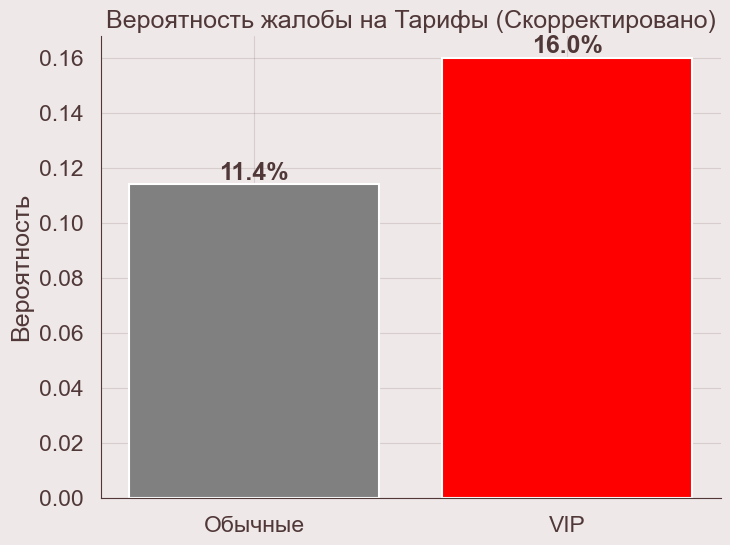

In [113]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("Уникальные значения эмоций:", df['review_emotion'].unique())

df['review_theme'] = df['review_theme'].astype(str).str.strip()

df['is_vip'] = df['influencer_flg'].fillna(0).astype(int)

negative_reviews = df[df['review_emotion'] == 0].copy()

if len(negative_reviews) == 0:
    raise ValueError("ОШИБКА: Не найдено ни одного негативного отзыва! Проверьте колонку review_emotion.")

print(f"Найдено негативных отзывов: {len(negative_reviews)}")

negative_reviews['target_is_tariff'] = negative_reviews['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

model_cols = ['target_is_tariff', 'is_vip', 'gender_cd', 'age_segment']
model_df = negative_reviews[model_cols].copy()

model_df['gender_cd'] = model_df['gender_cd'].fillna('Unknown')
model_df['age_segment'] = model_df['age_segment'].fillna('Unknown')

print(f"Данных для модели: {len(model_df)} строк")

model_df['is_male'] = (model_df['gender_cd'] == 'M').astype(int)
model_df = pd.get_dummies(model_df, columns=['age_segment'], drop_first=True)

X = model_df.drop(['target_is_tariff', 'gender_cd'], axis=1).astype(float)
X = sm.add_constant(X)
y = model_df['target_is_tariff']

if len(X) == 0:
    raise ValueError("ОШИБКА: Матрица X пуста. Проверьте данные.")

try:
    logit_model = sm.Logit(y, X).fit(disp=0)
    
    margeff = logit_model.get_margeff(at='overall')
    summary_frame = margeff.summary_frame()
    print(summary_frame)
    
    vip_effect = summary_frame.loc['is_vip']['dy/dx']
    vip_pval = summary_frame.loc['is_vip'].get('Pr(>|z|)', summary_frame.loc['is_vip'].get('P>|z|'))

    print("\n=== РЕЗУЛЬТАТЫ ===")
    print(f"Marginal Effect (VIP): +{vip_effect*100:.2f}%")
    print(f"P-value: {vip_pval:.6e}")
    
    p_base = y[X['is_vip'] == 0].mean()
    p_vip_adj = p_base + vip_effect
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Обычные', 'VIP'], [p_base, p_vip_adj], color=['gray', 'red'])
    plt.title('Вероятность жалобы на Тарифы (Скорректировано)')
    plt.ylabel('Вероятность')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1%}', 
                 ha='center', va='bottom', fontweight='bold')
    plt.show()

except Exception as e:
    print("Ошибка при построении модели:", e)
    print("Проверьте, есть ли вариативность в данных (не все ли значения одинаковые?)")